# Dependencies

In [1]:
#@title 1. Install Dependencies
!pip install ultralytics opencv-python-headless transformers accelerate gradio torch safetensors bitsandbytes -q -U einops numpy gensim scikit-learn
!pip install langchain langchain-openai torch torchvision openai --quiet
!pip install langchain_community
!pip install --upgrade langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.7/354.7 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# load dataset

我们会 load 两个文件夹, 一个是 train2024(images), 另一个是 annotations_trainval2014 (captions 以及 caption query index)

In [2]:
!wget http://images.cocodataset.org/zips/train2014.zip
!unzip train2014.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: train2014/COCO_train2014_000000408557.jpg  
 extracting: train2014/COCO_train2014_000000013714.jpg  
 extracting: train2014/COCO_train2014_000000194043.jpg  
 extracting: train2014/COCO_train2014_000000219859.jpg  
 extracting: train2014/COCO_train2014_000000278135.jpg  
 extracting: train2014/COCO_train2014_000000141015.jpg  
 extracting: train2014/COCO_train2014_000000280923.jpg  
 extracting: train2014/COCO_train2014_000000200024.jpg  
 extracting: train2014/COCO_train2014_000000435713.jpg  
 extracting: train2014/COCO_train2014_000000249993.jpg  
 extracting: train2014/COCO_train2014_000000424160.jpg  
 extracting: train2014/COCO_train2014_000000142761.jpg  
 extracting: train2014/COCO_train2014_000000532668.jpg  
 extracting: train2014/COCO_train2014_000000564904.jpg  
 extracting: train2014/COCO_train2014_000000346384.jpg  
 extracting: train2014/COCO_train2014_000000560934.jpg  
 extracting: train2014/COCO_train2014_000000122356.jpg  
 ext

In [2]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip annotations_trainval2014.zip


--2025-04-22 15:51:18--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.182.71.33, 52.216.54.1, 16.15.178.127, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.182.71.33|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  97.4MB/s    in 2.5s    

2025-04-22 15:51:21 (97.4 MB/s) - ‘annotations_trainval2014.zip’ saved [252872794/252872794]

Archive:  annotations_trainval2014.zip
  inflating: annotations/instances_train2014.json  
  inflating: annotations/instances_val2014.json  
  inflating: annotations/person_keypoints_train2014.json  
  inflating: annotations/person_keypoints_val2014.json  
  inflating: annotations/captions_train2014.json  
  inflating: annotations/captions_val2014.json  


## 尝试调用: 调用 caption 的方法和结构

`from pycocotools.coco import COCO`: `COCO` 并不会带任何图像或标注数据, 它是一个工具类, 类名叫 COCO, 帮你读取和操作一个你本地提供的 JSON 标注文件(比如 captions_train2014.json).



In [4]:
from pycocotools.coco import COCO

# 加载 captions 文件
ann_path = 'annotations/captions_train2014.json'
coco = COCO(ann_path)

# 随便选一个图像 ID（也可以从 coco.imgs.keys() 中选）
img_id = 222016

# 获取所有该图像的标注 ID
ann_ids = coco.getAnnIds(imgIds=img_id)
print(ann_ids)


# 获取这些标注的详细内容 (列表)
anns = coco.loadAnns(ann_ids)

# img_id = 222016 的对应 captions!
print(anns)
# 其中一条
print(anns[0])


loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
[813979, 814735, 816446, 816950, 817379]
[{'image_id': 222016, 'id': 813979, 'caption': 'a big red telephone booth that a man is standing in'}, {'image_id': 222016, 'id': 814735, 'caption': 'a person standing inside of a phone booth '}, {'image_id': 222016, 'id': 816446, 'caption': 'this is an image of a man in a phone booth.'}, {'image_id': 222016, 'id': 816950, 'caption': 'A man is standing in a red phone booth.'}, {'image_id': 222016, 'id': 817379, 'caption': 'A man using a phone in a phone booth.'}]
{'image_id': 222016, 'id': 813979, 'caption': 'a big red telephone booth that a man is standing in'}


`coco.imgs` 查看的是coco/annotations/captions_train2014.json 中所有 img ids

In [5]:
print(coco.imgs.keys())

dict_keys([57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570, 504616, 161919, 457732, 44404, 4428, 170558, 405613, 283524, 37015, 71631, 491269, 365363, 64460, 581674, 470072, 344806, 84427, 317237, 409382, 570608, 469605, 356702, 405207, 472925, 214704, 279108, 438422, 257350, 393493, 62426, 19380, 485894, 446014, 530683, 292835, 262845, 299411, 42493, 239811, 2024, 95133, 287541, 441488, 179620, 70000, 536587, 543877, 420721, 540162, 218956, 318574, 172899, 352884, 394326, 535786, 357684, 576757, 165499, 181104, 55627, 241364, 209967, 153674, 354444, 98760, 311914, 467311, 236772, 49183, 426038, 309322, 318189, 343322, 36633, 213546, 378710, 189993, 551125, 77806, 546451, 444546, 147016, 497616, 520208, 199628, 280980, 167613, 142088, 301778, 454325, 289019, 246804, 62604, 388911, 412535, 62279, 496939, 66514, 93785, 486320, 217306, 287927, 269829, 353139, 574001, 96557, 559527, 477797, 223726, 413746, 313932, 524068, 270912, 528906, 278347, 267688, 374114, 

In [6]:
import json

with open('annotations/captions_train2014.json', 'r') as f:
    # 先加载完整 JSON 数据（COCO 是字典）
    data = json.load(f)

# 打印顶层字段
print("Top-level keys:", list(data.keys()))

# 打印 info 字段
if 'info' in data:
    print("\ninfo:")
    print(json.dumps(data['info'], indent=2))

# 打印 images 列表中的前 1-2 个条目
if 'images' in data:
    print("\nFirst image entry:")
    print(json.dumps(data['images'][0], indent=2))

# 打印 annotations 列表中的前 1-2 个条目
if 'annotations' in data:
    print("\nFirst caption annotation:")
    print(json.dumps(data['annotations'][10:12], indent=2))


# 可以发现, data 是一个 dict, 包含四个 key, 其中两个是 images 和 annotations.
# 每个 key 的 value 是 a list of dicts
print(data.keys())
print(data["images"][0:2])


Top-level keys: ['info', 'images', 'licenses', 'annotations']

info:
{
  "description": "COCO 2014 Dataset",
  "url": "http://cocodataset.org",
  "version": "1.0",
  "year": 2014,
  "contributor": "COCO Consortium",
  "date_created": "2017/09/01"
}

First image entry:
{
  "license": 5,
  "file_name": "COCO_train2014_000000057870.jpg",
  "coco_url": "http://images.cocodataset.org/train2014/COCO_train2014_000000057870.jpg",
  "height": 480,
  "width": 640,
  "date_captured": "2013-11-14 16:28:13",
  "flickr_url": "http://farm4.staticflickr.com/3153/2970773875_164f0c0b83_z.jpg",
  "id": 57870
}

First caption annotation:
[
  {
    "image_id": 476220,
    "id": 314,
    "caption": "An empty kitchen with white and black appliances."
  },
  {
    "image_id": 299675,
    "id": 328,
    "caption": "A white square kitchen with tile floor that needs repairs "
  }
]
dict_keys(['info', 'images', 'licenses', 'annotations'])
[{'license': 5, 'file_name': 'COCO_train2014_000000057870.jpg', 'coco_url':

## 尝试: 增加一个 (virtual) 图片

In [7]:
!mkdir appended_train

In [8]:
# 随便选一个图像 ID（也可以从 coco.imgs.keys() 中选）
img_id = 57870
# 获取所有该图像的标注 ID
ann_ids = coco.getAnnIds(imgIds=img_id)
print(ann_ids)

[787980, 789366, 789888, 791316, 794853]


In [9]:
new_image_id = 578701  # 增加一位数, 保证唯一
new_image = {
    "license": 5,
    "file_name": "custom_image_0000000578701.jpg",
    "coco_url": "",
    "height": 480,
    "width": 640,
    "date_captured": "2025-04-21 12:00:00",
    "flickr_url": "",
    "id": new_image_id
}

new_caption = {
  "image_id": 578701,
  "id": 7879801,
  "caption": "A very clean and well decorated empty kitchen"
}

with open('annotations/captions_train2014.json', 'r') as f:
    data = json.load(f)

data['images'].append(new_image)
data['annotations'].append(new_caption)

# 5. 保存新的 JSON 文件
with open('annotations/captions_train2014_modified.json', 'w') as f:
    json.dump(data, f, indent=2)

print(data['images'][-1])
print(data['annotations'][-1])

{'license': 5, 'file_name': 'custom_image_0000000578701.jpg', 'coco_url': '', 'height': 480, 'width': 640, 'date_captured': '2025-04-21 12:00:00', 'flickr_url': '', 'id': 578701}
{'image_id': 578701, 'id': 7879801, 'caption': 'A very clean and well decorated empty kitchen'}


In [10]:
coco = COCO('annotations/captions_train2014_modified.json')

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [11]:
img_id = 578701
# 获取所有该图像的标注 ID

ann_ids = coco.getAnnIds(imgIds=img_id)
print(ann_ids)

[7879801]


## 测试完毕, 删除刚才的 virtual image 和它的 caption

In [12]:
# 1. 读取数据
with open('annotations/captions_train2014_modified.json', 'r') as f:
    data = json.load(f)

# 2. 设定要删除的 image_id 和 annotation_id
delete_image_id = 578701

# 3. 删除 images 中对应的条目
data['images'] = [img for img in data['images'] if img['id'] != delete_image_id]

# 4. 删除 annotations 中所有与该 image_id 对应的 caption
data['annotations'] = [ann for ann in data['annotations'] if ann['image_id'] != delete_image_id]

# 5. 写回文件
with open('annotations/captions_train2014_modified.json', 'w') as f:
    json.dump(data, f, indent=2)


coco = COCO('annotations/captions_train2014_modified.json')
img_id = 578701
# 获取所有该图像的标注 ID

ann_ids = coco.getAnnIds(imgIds=img_id)
print(ann_ids)

loading annotations into memory...
Done (t=0.70s)
creating index...
index created!
[]


In [13]:
#coco 多大
print(len(coco.imgs))
print(len(coco.anns))

82783
414113


# Step 0: 数据预处理. 抽取前 `K`(batchsize) 张 images, 以及它们对应的第一个 caption, 即 `K` 个 (image,caption) pair.

In [1]:
from pycocotools.coco import COCO
import json
ann_path = 'annotations/captions_train2014.json'
coco = COCO(ann_path)
with open('annotations/captions_train2014_modified.json', 'r') as f:
    data = json.load(f)

start = 0  # start index
batch_size = 20

image_caption_pairs = []
for i in range(start, start+batch_size):
  image_entry = data["images"][i]

  current_image_filename = "train2014/" + image_entry["file_name"]
  current_image_id = image_entry["id"]
  print("Current image: ", current_image_filename," id: ",current_image_id)

  current_ann_ids = coco.getAnnIds(imgIds=current_image_id)
  current_caption = coco.loadAnns(current_ann_ids)[0]['caption']
  current_caption_id = coco.loadAnns(current_ann_ids)[0]['id']
  print("Current caption: ", current_caption," id: ", current_caption_id)

  image_caption_pairs.append((current_image_filename, current_image_id, current_caption, current_caption_id))

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!
Current image:  train2014/COCO_train2014_000000057870.jpg  id:  57870
Current caption:  A restaurant has modern wooden tables and chairs.  id:  787980
Current image:  train2014/COCO_train2014_000000384029.jpg  id:  384029
Current caption:  A man preparing desserts in a kitchen covered in frosting.  id:  118034
Current image:  train2014/COCO_train2014_000000222016.jpg  id:  222016
Current caption:  a big red telephone booth that a man is standing in  id:  813979
Current image:  train2014/COCO_train2014_000000520950.jpg  id:  520950
Current caption:  the kitchen is full of spices on the rack  id:  636271
Current image:  train2014/COCO_train2014_000000069675.jpg  id:  69675
Current caption:  A child and woman are cooking in the kitchen.  id:  72465
Current image:  train2014/COCO_train2014_000000547471.jpg  id:  547471
Current caption:  A black and white image of a man in a suit wearing glasses walking throu

## 所有 (image, caption) pair 的 show

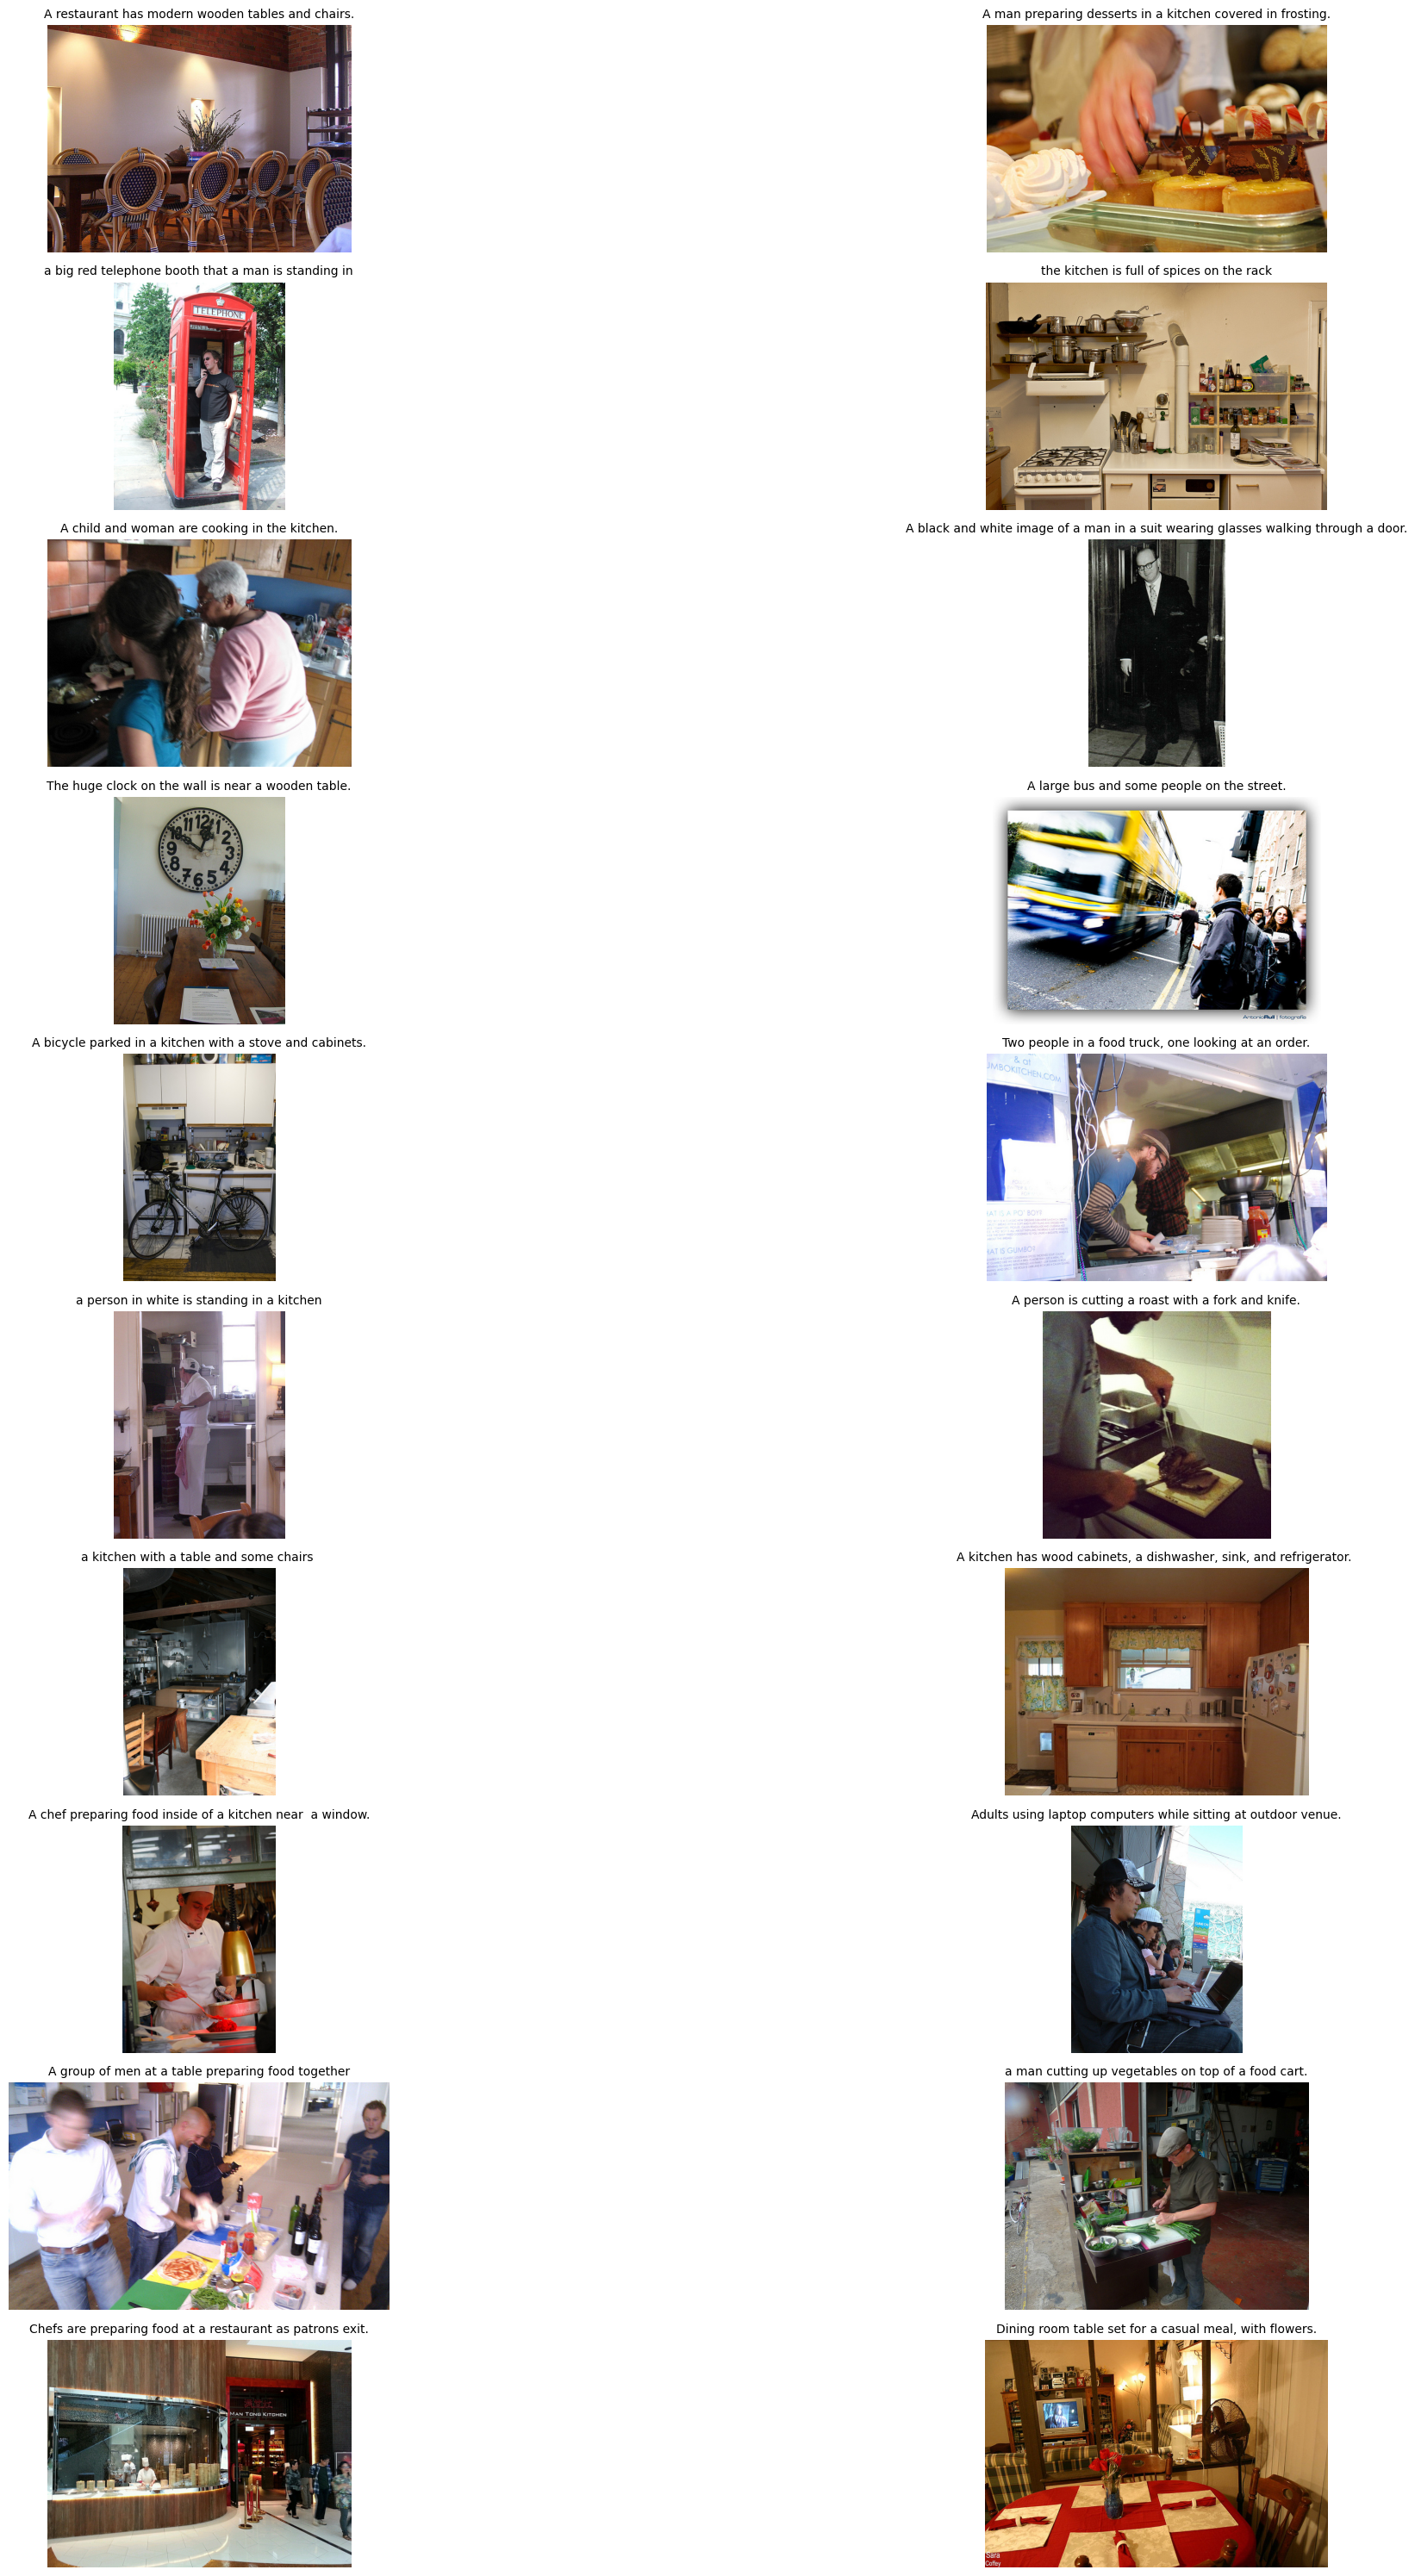

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Display settings
cols = 2
rows = (len(image_caption_pairs) + cols - 1) // cols
fig, axs = plt.subplots(rows, cols, figsize=(30, 30))
axs = axs.flatten()

# Plot each image with its caption
for i, (img_path, img_ID, caption, caption_id) in enumerate(image_caption_pairs):
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].set_title(caption, fontsize=10)
    else:
        axs[i].text(0.5, 0.5, 'Image not found', ha='center', va='center')
    axs[i].axis('off')


# Turn off unused axes
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## 存一下本次 batch 的图片

In [3]:
import os
import shutil
batchimagefolder="BatchImageFolder"
os.makedirs(batchimagefolder, exist_ok=True)
for i, (img_path, img_ID, caption, caption_id) in enumerate(image_caption_pairs):
    if os.path.isfile(img_path):  # 确保文件存在
        # 获取原始文件名
        filename = os.path.basename(img_path)
        # 构建新的路径
        dest_path = os.path.join(batchimagefolder, filename)
        # 复制文件
        shutil.copy(img_path, dest_path)
        print(f"Copied {img_path} to {dest_path}")
    else:
        print(f"Warning: File {img_path} does not exist.")

Copied train2014/COCO_train2014_000000057870.jpg to BatchImageFolder/COCO_train2014_000000057870.jpg
Copied train2014/COCO_train2014_000000384029.jpg to BatchImageFolder/COCO_train2014_000000384029.jpg
Copied train2014/COCO_train2014_000000222016.jpg to BatchImageFolder/COCO_train2014_000000222016.jpg
Copied train2014/COCO_train2014_000000520950.jpg to BatchImageFolder/COCO_train2014_000000520950.jpg
Copied train2014/COCO_train2014_000000069675.jpg to BatchImageFolder/COCO_train2014_000000069675.jpg
Copied train2014/COCO_train2014_000000547471.jpg to BatchImageFolder/COCO_train2014_000000547471.jpg
Copied train2014/COCO_train2014_000000122688.jpg to BatchImageFolder/COCO_train2014_000000122688.jpg
Copied train2014/COCO_train2014_000000392136.jpg to BatchImageFolder/COCO_train2014_000000392136.jpg
Copied train2014/COCO_train2014_000000398494.jpg to BatchImageFolder/COCO_train2014_000000398494.jpg
Copied train2014/COCO_train2014_000000090570.jpg to BatchImageFolder/COCO_train2014_0000000

# Step 1: 预处理结束, 现在对 image_caption_pairs 进行流程. 1. 提取关键词与映射

In [ ]:
# ----------------------------------------
# (1) imports and api key preparation
# ----------------------------------------
import os
import json
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage
from langchain_openai import ChatOpenAI
import re

openai_api_key = input("Please input your OpenAI API key")
assert openai_api_key.startswith(openai_api_key)
# Initialize the model (use environment variables for API key)
eval_chat_model = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0,
    openai_api_key=openai_api_key
)

YOLOKeyWords = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train",
    "truck", "boat", "traffic light", "fire hydrant", "stop sign",
    "parking meter", "bench", "bird", "cat", "dog", "horse", "sheep",
    "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella",
    "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork",
    "knife", "spoon", "bowl", "banana", "apple", "sandwich", "orange",
    "broccoli", "carrot", "hot dog", "pizza", "donut", "cake", "chair",
    "couch", "potted plant", "bed", "dining table", "toilet", "tv",
    "laptop", "mouse", "remote", "keyboard", "cell phone", "microwave",
    "oven", "toaster", "sink", "refrigerator", "book", "clock", "vase",
    "scissors", "teddy bear", "hair drier", "toothbrush"
]


In [5]:
# ----------------------------------------
# (2) We got Prompt
# ----------------------------------------
TASK_PROMPT = """Perform the following:
1. Extract up to 3 key nouns from the description
2. For each noun, find its corresponding YOLO category (from list below)
3. Only keep nouns that successfully mapped to a YOLO category

YOLO Categories:
{categories}

Description:
{caption}

Response Format (strictly follow):
Original Noun | YOLO Category
---
Example1:
bathroom | toilet
decor |

Example2:
stop sign | stop sign
car | car
"""

# ----------------------------------------
# STEP 8: Updated Parsing Logic
# ----------------------------------------
from collections import defaultdict

caption_data = []
# Create the prompt template
prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content="You are an expert at extracting nouns and mapping them to YOLO object categories."),
    HumanMessagePromptTemplate.from_template(TASK_PROMPT)
])

captions = []
for j in range(batch_size):
  caption = image_caption_pairs[j][2]
  captions.append(caption)



for idx, caption in enumerate(captions[:batch_size]):
    print(f"\nProcessing caption {idx+1}: {caption}")
    messages = prompt_template.format_messages(
        caption=caption,
        categories=YOLOKeyWords
    )

    try:
        response = eval_chat_model.invoke(messages)
        print(f"Raw response:\n{response.content}")

        # Parse response
        valid_mappings = defaultdict(str)

        # Split response lines
        lines = response.content.split('\n')
        for line in lines:
            if '|' in line:  # Check separator
                parts = line.split('|')
                if len(parts) == 2:
                    original_noun = parts[0].strip().lower()
                    yolo_cat = parts[1].strip().lower()

                    # Validate YOLO category
                    if yolo_cat in YOLOKeyWords:
                        valid_mappings[original_noun] = yolo_cat

        print(f"Valid mappings:")
        for noun, cat in valid_mappings.items():
            print(f"  {noun} → {cat}")

        caption_data.append(
            dict(valid_mappings)
        )

    except Exception as e:
        print(f"Error: {str(e)}")


Processing caption 1: A restaurant has modern wooden tables and chairs.
Raw response:
Original Noun | YOLO Category
---
restaurant | 
tables | dining table
chairs | chair
Valid mappings:
  tables → dining table
  chairs → chair

Processing caption 2: A man preparing desserts in a kitchen covered in frosting.
Raw response:
Original Noun | YOLO Category
---
man | person
desserts | cake
kitchen | potted plant
Valid mappings:
  man → person
  desserts → cake
  kitchen → potted plant

Processing caption 3: a big red telephone booth that a man is standing in
Raw response:
Original Noun | YOLO Category
---
telephone booth | bench
man | person
Valid mappings:
  telephone booth → bench
  man → person

Processing caption 4: the kitchen is full of spices on the rack
Raw response:
Original Noun | YOLO Category
---
kitchen | potted plant
spices | bowl
rack | chair
Valid mappings:
  kitchen → potted plant
  spices → bowl
  rack → chair

Processing caption 5: A child and woman are cooking in the kit

In [6]:
for i in range(len(caption_data)):
  print(str(caption_data[i]) + ',')
print("total entries: ", len(caption_data))

{'tables': 'dining table', 'chairs': 'chair'},
{'man': 'person', 'desserts': 'cake', 'kitchen': 'potted plant'},
{'telephone booth': 'bench', 'man': 'person'},
{'kitchen': 'potted plant', 'spices': 'bowl', 'rack': 'chair'},
{'child': 'person', 'woman': 'person', 'kitchen': 'potted plant'},
{'man': 'person'},
{'clock': 'clock', 'table': 'dining table'},
{'bus': 'bus', 'people': 'person'},
{'bicycle': 'bicycle'},
{'people': 'person', 'food truck': 'truck'},
{'person': 'person'},
{'person': 'person', 'fork': 'fork', 'knife': 'knife'},
{'kitchen': 'potted plant', 'table': 'dining table', 'chairs': 'chair'},
{'kitchen': 'potted plant', 'cabinets': 'potted plant', 'dishwasher': 'potted plant'},
{'chef': 'person', 'kitchen': 'dining table'},
{'adults': 'person', 'laptop computers': 'laptop'},
{'men': 'person', 'table': 'dining table', 'food': 'banana'},
{'man': 'person', 'vegetables': 'broccoli'},
{'chefs': 'person'},
{'table': 'dining table', 'flowers': 'vase'},
total entries:  20


# Step 2. Segmentation

In [7]:
import torch
from PIL import Image, ImageDraw
import os
import cv2
import numpy as np
from ultralytics import YOLO
import torch.nn.functional as F

maskFolder = "MasksFolder"
os.makedirs(maskFolder, exist_ok=True)
#@title yolo
model = YOLO("yolov8n-seg.pt")

## run for batch. Notice: 如果 mask 全黑则不保存, 并且更新 caption-data

In [8]:
def enlarge_mask_by_pixels(mask, pixels=20):
    kernel_size = pixels * 2 + 1  # ensures dilation covers 20 pixels in all directions
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated = cv2.dilate(mask, kernel, iterations=1)
    return dilated

updated_caption_data = []
# Loop through each image-caption pair and caption keyword dict
for i, (img_path, img_id, caption, caption_id) in enumerate(image_caption_pairs):
    keyword_class_map = caption_data[i]  # e.g., {'man': 'person', 'cake': 'cake'}
    target_classes = set(keyword_class_map.values())

    # Load image
    img = cv2.imread(img_path)

    height, width = img.shape[:2]
    results = model(img_path)

    # Initialize masks
    combined_masks = {label: np.zeros((height, width), dtype=np.uint8) for label in target_classes}


    for result in results:
        for j in range(len(result.boxes)):
            class_id = int(result.boxes.cls[j])
            label = model.names[class_id]
            if label in target_classes:
                mask = result.masks.data[j].cpu().numpy()
                mask = (mask > 0.2).astype(np.uint8) * 255
                if mask.shape != (height, width):
                    mask = cv2.resize(mask, (width, height), interpolation=cv2.INTER_NEAREST)
                    enlarged_mask = enlarge_mask_by_pixels(mask, pixels=20)
                    combined_masks[label] = cv2.bitwise_or(combined_masks[label], enlarged_mask)

    # Save masks for each detected class
    updated_mapping = {}
    for label, mask in combined_masks.items():
        if np.any(mask):  # Only save non-zero masks
            mask_path = os.path.join(maskFolder, f"{img_id}-{label}.jpg")
            cv2.imwrite(mask_path, mask)
            keywords = [k for k, v in keyword_class_map.items() if v == label]
            for keyword in keywords:
                updated_mapping[keyword] = label # reverse map
            print(f"[{i}] Saved non-zero mask for '{label}' → {mask_path}")
        else:
            print(f"[{i}] Skipped '{label}' — mask is all black.")

    updated_caption_data.append(updated_mapping)


image 1/1 /content/train2014/COCO_train2014_000000057870.jpg: 480x640 1 person, 7 chairs, 1 potted plant, 2 dining tables, 65.9ms
Speed: 8.6ms preprocess, 65.9ms inference, 391.4ms postprocess per image at shape (1, 3, 480, 640)
[0] Skipped 'dining table' — mask is all black.
[0] Skipped 'chair' — mask is all black.

image 1/1 /content/train2014/COCO_train2014_000000384029.jpg: 448x640 1 person, 3 donuts, 4 cakes, 64.3ms
Speed: 1.6ms preprocess, 64.3ms inference, 3.3ms postprocess per image at shape (1, 3, 448, 640)
[1] Skipped 'potted plant' — mask is all black.
[1] Saved non-zero mask for 'cake' → MasksFolder/384029-cake.jpg
[1] Saved non-zero mask for 'person' → MasksFolder/384029-person.jpg

image 1/1 /content/train2014/COCO_train2014_000000222016.jpg: 640x480 1 person, 1 tv, 66.1ms
Speed: 1.8ms preprocess, 66.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)
[2] Skipped 'bench' — mask is all black.
[2] Skipped 'person' — mask is all black.

image 1/1 /content/t

## 质量抽查

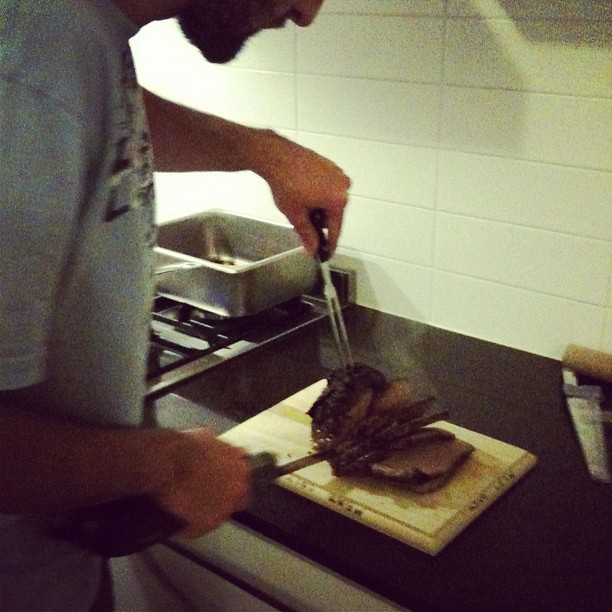

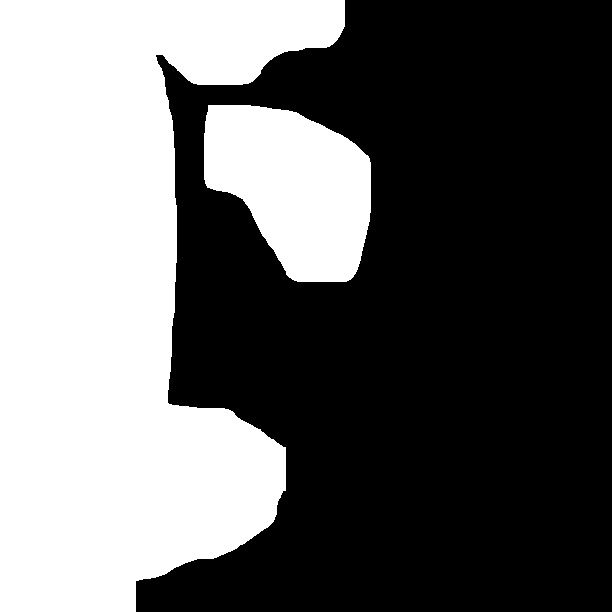

In [9]:
# 测试:
img_path = "train2014/COCO_train2014_000000161919.jpg"
image = Image.open(img_path)
display(image)
image2 = Image.open("MasksFolder/161919-person.jpg")
display(image2)

In [10]:
for i in range(len(updated_caption_data)):
  print(str(updated_caption_data[i]) + ',')

{},
{'desserts': 'cake', 'man': 'person'},
{},
{},
{},
{'man': 'person'},
{},
{'bus': 'bus', 'people': 'person'},
{'bicycle': 'bicycle'},
{'people': 'person'},
{},
{'person': 'person'},
{'table': 'dining table', 'chairs': 'chair'},
{},
{'chef': 'person'},
{'laptop computers': 'laptop', 'adults': 'person'},
{'table': 'dining table', 'men': 'person'},
{},
{},
{'table': 'dining table', 'flowers': 'vase'},


In [11]:
caption_data = updated_caption_data

## blend 测试

In [12]:
maskFolder = "MasksFolder"
testMaskBlendFolder = "MaskBlendTestingFolder"
os.makedirs(testMaskBlendFolder, exist_ok=True)

In [13]:
# Placeholder function for diffusion (mock)
def blend(prompt, image, mask):
    return Image.blend(image, mask, alpha=0.5)

# Run diffusion based on caption_data and image_caption_pairs (by index)
for i, (img_path, img_id, caption, caption_id) in enumerate(image_caption_pairs):
    label_class_map = caption_data[i]  # e.g. {'person': 'person', 'cake': 'cake'}

    if not os.path.exists(img_path):
        print(f"[{i}] Image not found: {img_path}")
        image = Image.new("RGB", (256, 256), color=(100, 100, 100))  # Placeholder
    else:
        image = Image.open(img_path).convert("RGB")

    for keyword, label in label_class_map.items():
        mask_filename = f"{img_id}-{label}.jpg"
        mask_path = os.path.join(maskFolder, mask_filename)

        if not os.path.exists(mask_path):
            print(f"[{i}] Mask not found: {mask_path}")
            continue

        mask = Image.open(mask_path).convert("RGB")
        prompt = caption
        output_path = os.path.join(testMaskBlendFolder, mask_filename)

        result = blend(prompt, image, mask)
        result.save(output_path)
        print(f"[{i}] Inpainted and saved: {output_path}")

[1] Inpainted and saved: MaskBlendTestingFolder/384029-cake.jpg
[1] Inpainted and saved: MaskBlendTestingFolder/384029-person.jpg
[5] Inpainted and saved: MaskBlendTestingFolder/547471-person.jpg
[7] Inpainted and saved: MaskBlendTestingFolder/392136-bus.jpg
[7] Inpainted and saved: MaskBlendTestingFolder/392136-person.jpg
[8] Inpainted and saved: MaskBlendTestingFolder/398494-bicycle.jpg
[9] Inpainted and saved: MaskBlendTestingFolder/90570-person.jpg
[11] Inpainted and saved: MaskBlendTestingFolder/161919-person.jpg
[12] Inpainted and saved: MaskBlendTestingFolder/457732-dining table.jpg
[12] Inpainted and saved: MaskBlendTestingFolder/457732-chair.jpg
[14] Inpainted and saved: MaskBlendTestingFolder/4428-person.jpg
[15] Inpainted and saved: MaskBlendTestingFolder/170558-laptop.jpg
[15] Inpainted and saved: MaskBlendTestingFolder/170558-person.jpg
[16] Inpainted and saved: MaskBlendTestingFolder/405613-dining table.jpg
[16] Inpainted and saved: MaskBlendTestingFolder/405613-person.jp

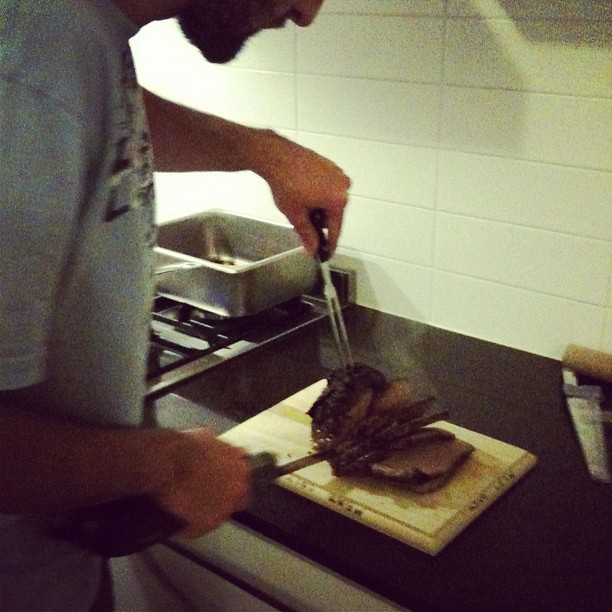

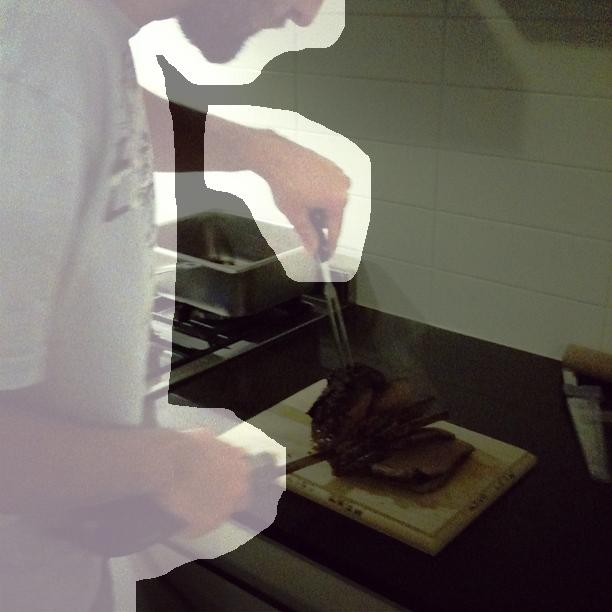

In [14]:
# 测试:
img_path = "train2014/COCO_train2014_000000161919.jpg"
image = Image.open(img_path)
display(image)
image2 = Image.open("MaskBlendTestingFolder/161919-person.jpg")
display(image2)

# Step 3. Stable Diffusion

In [15]:
from diffusers import StableDiffusionInpaintPipeline
#@title stable diffusion
model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [16]:
maskFolder = "MasksFolder"
outputFolder = "DualImageFolder"
os.makedirs(outputFolder, exist_ok=True)

In [17]:


# Run diffusion based on caption_data and image_caption_pairs (by index)
for i, (img_path, img_id, caption, caption_id) in enumerate(image_caption_pairs):
    label_class_map = caption_data[i]  # e.g. {'person': 'person', 'cake': 'cake'}

    if not os.path.exists(img_path):
        print(f"[{i}] Image not found: {img_path}")
        image = Image.new("RGB", (256, 256), color=(100, 100, 100))  # Placeholder
    else:
        image = Image.open(img_path).convert("RGB")

    for keyword, label in label_class_map.items():
        mask_filename = f"{img_id}-{label}.jpg"
        mask_path = os.path.join(maskFolder, mask_filename)

        if not os.path.exists(mask_path):
            print(f"[{i}] Mask not found: {mask_path}")
            continue

        mask = Image.open(mask_path).convert("RGB")
        prompt = caption
        output_path = os.path.join(outputFolder, mask_filename)

        Prompt = "A clean background, natural surroundings, no people, no object, strictly avoid objects in negative prompt"
        negativePrompt = keyword + ", " + label
        result = pipe(prompt=Prompt, negative_prompt=negativePrompt,image=image, mask_image=mask).images[0]
        result.save(output_path)
        print(f"[{i}] Inpainted and saved: {output_path}")

  0%|          | 0/50 [00:00<?, ?it/s]

[1] Inpainted and saved: DualImageFolder/384029-cake.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[1] Inpainted and saved: DualImageFolder/384029-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[5] Inpainted and saved: DualImageFolder/547471-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[7] Inpainted and saved: DualImageFolder/392136-bus.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[7] Inpainted and saved: DualImageFolder/392136-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[8] Inpainted and saved: DualImageFolder/398494-bicycle.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[9] Inpainted and saved: DualImageFolder/90570-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[11] Inpainted and saved: DualImageFolder/161919-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[12] Inpainted and saved: DualImageFolder/457732-dining table.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[12] Inpainted and saved: DualImageFolder/457732-chair.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[14] Inpainted and saved: DualImageFolder/4428-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[15] Inpainted and saved: DualImageFolder/170558-laptop.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[15] Inpainted and saved: DualImageFolder/170558-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[16] Inpainted and saved: DualImageFolder/405613-dining table.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[16] Inpainted and saved: DualImageFolder/405613-person.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[19] Inpainted and saved: DualImageFolder/71631-dining table.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

[19] Inpainted and saved: DualImageFolder/71631-vase.jpg


## 质量抽查


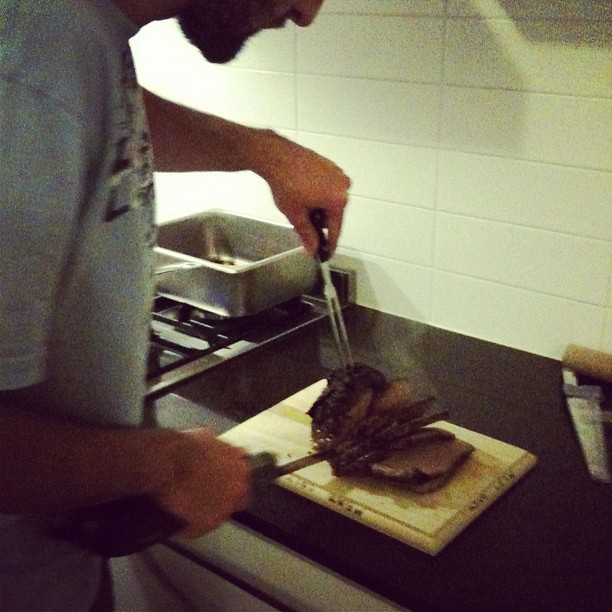

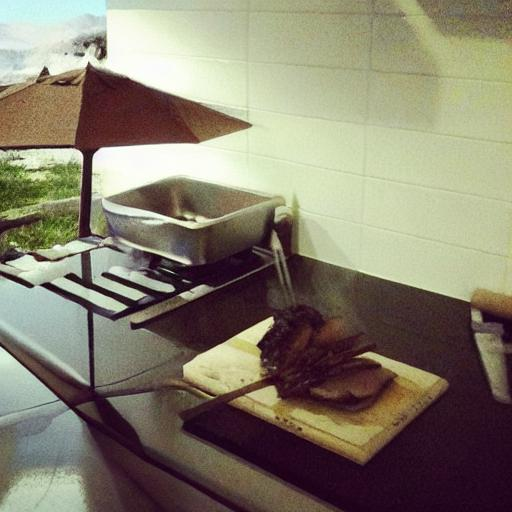

In [18]:
# 测试:
img_path = "train2014/COCO_train2014_000000161919.jpg"
image = Image.open(img_path)
display(image)
image2 = Image.open(f"{outputFolder}/161919-person.jpg")
display(image2)

# Step 4. Dual caption

In [19]:
for i in range(len(image_caption_pairs)):
  print(i, str(image_caption_pairs[i]) + ',')
len(image_caption_pairs)

0 ('train2014/COCO_train2014_000000057870.jpg', 57870, 'A restaurant has modern wooden tables and chairs.', 787980),
1 ('train2014/COCO_train2014_000000384029.jpg', 384029, 'A man preparing desserts in a kitchen covered in frosting.', 118034),
2 ('train2014/COCO_train2014_000000222016.jpg', 222016, 'a big red telephone booth that a man is standing in', 813979),
3 ('train2014/COCO_train2014_000000520950.jpg', 520950, 'the kitchen is full of spices on the rack', 636271),
4 ('train2014/COCO_train2014_000000069675.jpg', 69675, 'A child and woman are cooking in the kitchen.', 72465),
5 ('train2014/COCO_train2014_000000547471.jpg', 547471, 'A black and white image of a man in a suit wearing glasses walking through a door.', 256750),
6 ('train2014/COCO_train2014_000000122688.jpg', 122688, 'The huge clock on the wall is near a wooden table.', 390926),
7 ('train2014/COCO_train2014_000000392136.jpg', 392136, 'A large bus and some people on the street.', 562912),
8 ('train2014/COCO_train2014_0000

20

In [20]:
for i in range(len(caption_data)):
  print(i, str(caption_data[i]) + ',')

0 {},
1 {'desserts': 'cake', 'man': 'person'},
2 {},
3 {},
4 {},
5 {'man': 'person'},
6 {},
7 {'bus': 'bus', 'people': 'person'},
8 {'bicycle': 'bicycle'},
9 {'people': 'person'},
10 {},
11 {'person': 'person'},
12 {'table': 'dining table', 'chairs': 'chair'},
13 {},
14 {'chef': 'person'},
15 {'laptop computers': 'laptop', 'adults': 'person'},
16 {'table': 'dining table', 'men': 'person'},
17 {},
18 {},
19 {'table': 'dining table', 'flowers': 'vase'},


## prompt

In [21]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain_core.messages import SystemMessage

openai_api_key = input("Please input your OpenAI API key")
assert openai_api_key.startswith(openai_api_key)

eval_chat_model = ChatOpenAI(
    model="gpt-4",
    temperature=0,
    openai_api_key=openai_api_key
)

REWRITE_PROMPT = """ Given a caption and a specific noun in it, your task is to rewrite the caption by removing the noun together with all its related words (such as active and passive behavior), from the caption.
Notice: Do not only remove the noun, but also all related words! Also, changing the noun to its synonym does not really work! It is okay to make the caption short.

Below are three example I made:
(1)Caption: "A black and white image of a man in a suit wearing glasses walking through a door.",
	 keyword: "man",
	 Rewritten caption: "A black and white image of a door."
(2)Caption: "An officer in a reflective vest stands at the front of his van with his dog."
	 keyword: "officer"
	 Rewritten caption: "There is a dog at the front of a van."
(3)Caption: "A man preparing desserts in a kitchen covered in frosting."
   keyword: "man"
   Rewritten caption: "Some desserts in a kitchen covered in frosting."

Now you do it:
Original Caption: "{caption}"
Remove Noun: "{noun}"

Rewritten Caption:"""

rewrite_prompt_template = ChatPromptTemplate.from_messages([
    SystemMessage(content="You rewrite image captions by dropping the specified noun."),
    HumanMessagePromptTemplate.from_template(REWRITE_PROMPT)
])

## get

In [28]:
# output container
dual_caption_data = []

for j in range(batch_size):
    entry = caption_data[j]
    orig = image_caption_pairs[j][2]  # Get original caption
    noun_map = entry  # recall: this is a dict: noun -> yolo_category
    # if noun_map empty then we ignore this entry
    if not noun_map:
        continue
    # Collect rewrites for this caption.
    rewrites = []
    for noun in noun_map.keys():
        messages = rewrite_prompt_template.format_messages(
            caption=orig,
            noun=noun
        )
        try:
            resp = eval_chat_model.invoke(messages)
            text = resp.content.strip()
            rewrites.append({
                "removed_noun": noun,
                "removed_noun_category": noun_map[noun],
                "rewritten_caption": text
            })
        except Exception as e:
            print(f"Error rewriting '{orig}' without '{noun}': {e}")

    # Store results
    dual_caption_data.append({
        "original_caption": orig,
        "original_caption_id": image_caption_pairs[j][3],
        "original_imd_id": image_caption_pairs[j][1],
        "rewrites": rewrites
    })

    # —— Grouped print right here ——
    print(f'\nOriginal Caption: "{orig}"')
    if rewrites:
        for i, rw in enumerate(rewrites, 1):
            print(f'For caption {j}, Dual_Caption {i} (removed “{rw["removed_noun"]}”): {rw["rewritten_caption"]}')
    else:
        print("  (no valid mapped nouns to remove)")
    print("-" * 60)



Original Caption: "A man preparing desserts in a kitchen covered in frosting."
For caption 1, Dual_Caption 1 (removed “desserts”): "A man in a kitchen covered in frosting."
For caption 1, Dual_Caption 2 (removed “man”): "Desserts being prepared in a kitchen covered in frosting."
------------------------------------------------------------

Original Caption: "A black and white image of a man in a suit wearing glasses walking through a door."
For caption 5, Dual_Caption 1 (removed “man”): "A black and white image of a door."
------------------------------------------------------------

Original Caption: "A large bus and some people on the street."
For caption 7, Dual_Caption 1 (removed “bus”): "Some people on the street."
For caption 7, Dual_Caption 2 (removed “people”): "A large bus on the street."
------------------------------------------------------------

Original Caption: "A bicycle parked in a kitchen with a stove and cabinets."
For caption 8, Dual_Caption 1 (removed “bicycle”): 

In [29]:
print(len(dual_caption_data))
for i in range(len(dual_caption_data)):
  print(i, str(dual_caption_data[i]) + ',')

11
0 {'original_caption': 'A man preparing desserts in a kitchen covered in frosting.', 'original_caption_id': 118034, 'original_imd_id': 384029, 'rewrites': [{'removed_noun': 'desserts', 'removed_noun_category': 'cake', 'rewritten_caption': '"A man in a kitchen covered in frosting."'}, {'removed_noun': 'man', 'removed_noun_category': 'person', 'rewritten_caption': '"Desserts being prepared in a kitchen covered in frosting."'}]},
1 {'original_caption': 'A black and white image of a man in a suit wearing glasses walking through a door.', 'original_caption_id': 256750, 'original_imd_id': 547471, 'rewrites': [{'removed_noun': 'man', 'removed_noun_category': 'person', 'rewritten_caption': '"A black and white image of a door."'}]},
2 {'original_caption': 'A large bus and some people on the street.', 'original_caption_id': 562912, 'original_imd_id': 392136, 'rewrites': [{'removed_noun': 'bus', 'removed_noun_category': 'bus', 'rewritten_caption': '"Some people on the street."'}, {'removed_nou

# 后续: 保存数据为 coco 格式, 自定义格式以及下载

fucking google colab 不能下载文件夹, 逆天

## 输出1: 把输出文件夹打 zip 直接 download

In [26]:
import shutil
shutil.make_archive('DualImageFolder', 'zip', 'DualImageFolder')

'/content/DualImageFolder.zip'

In [27]:
from google.colab import files
files.download('DualImageFolder.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 输出 2: 更改 annotation 的 json 文件, 直接引入 coco 模式

In [ ]:
new_image_id = 578701  # 增加一位数, 保证唯一
new_image = {
    "license": 5,
    "file_name": "custom_image_0000000578701.jpg",
    "coco_url": "",
    "height": 480,
    "width": 640,
    "date_captured": "2025-04-21 12:00:00",
    "flickr_url": "",
    "id": new_image_id
}

new_caption = {
  "image_id": 578701,
  "id": 7879801,
  "caption": "A very clean and well decorated empty kitchen"
}

with open('annotations/captions_train2014.json', 'r') as f:
    data = json.load(f)

data['images'].append(new_image)
data['annotations'].append(new_caption)

# 5. 保存新的 JSON 文件
with open('annotations/captions_train2014_modified.json', 'w') as f:
    json.dump(data, f, indent=2)

print(data['images'][-1])
print(data['annotations'][-1])